In [1]:
from src.base_models import *
from src.dataset_lib import *
from src.ode_solvers import *
from src.comp_models import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
GaussianMix = GaussianMixture.symmetric_2D(5,1.0)

gaussian_path = GaussianConditionalProbabilityPath(p_data=GaussianMix, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model1 = BasicMLP(input_dim=2, hidden_dims=[64,64,64,64])

trainer = FlowDiffTrainer(path=gaussian_path, modeltype="Diffusion", model=model1)

trainer.train_loop(num_epochs=5000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 6.7528076171875
In Epoch 1000 we have a loss of 5.302724838256836
In Epoch 2000 we have a loss of 6.886566638946533
In Epoch 3000 we have a loss of 7.816971778869629
In Epoch 4000 we have a loss of 4.044712543487549


In [3]:
swiss = GaussianMixture.symmetric_2D(3,1.0)

gaussian_path2 = GaussianConditionalProbabilityPath(p_data=swiss, alpha=LinearAlpha(), beta = SquareRootBeta(), device=device).to(device)

model2 = BasicMLP(input_dim=2, hidden_dims=[64,64,64,64])

trainer2 = FlowDiffTrainer(path=gaussian_path2, modeltype="Diffusion", model=model2)

trainer2.train_loop(num_epochs=5000, device=device, lr=1e-3, n= 1000)

In Epoch 0 we have a loss of 44.499755859375
In Epoch 1000 we have a loss of 7.652054309844971
In Epoch 2000 we have a loss of 8.029156684875488
In Epoch 3000 we have a loss of 6.99163293838501
In Epoch 4000 we have a loss of 10.794065475463867


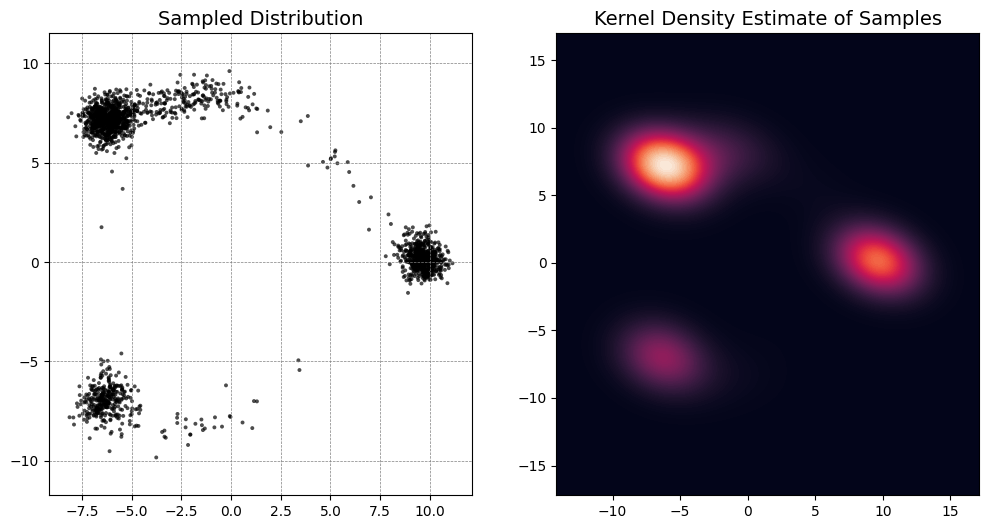

In [4]:
models = [model1,model2]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 
samples = comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps)
figsize=(12, 6)

fig, axes = plt.subplots(1, 2, figsize = figsize)
plot_samples(samples, ax=axes[0])
plot_kde(samples, ax = axes[1], cmap="rocket")

plt.show()

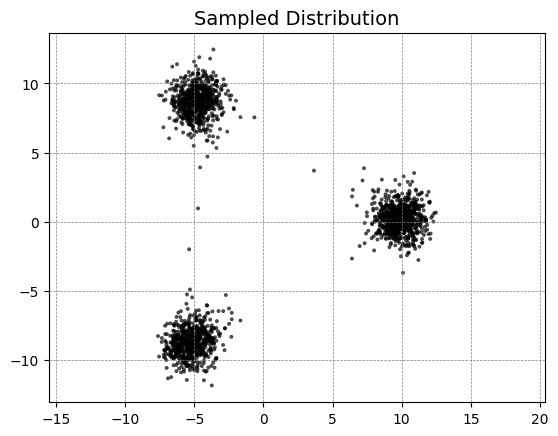

In [5]:
models = [model2]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 

plot_samples(comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps),contour=False)

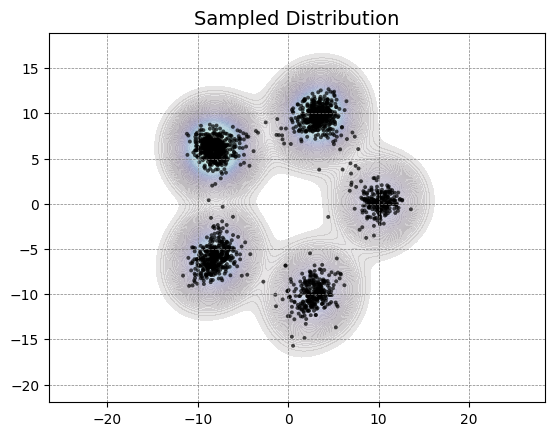

In [6]:
models = [model1]

sde = CompLangevin(models=models, sigma = 1, alpha = LinearAlpha(), beta=SquareRootBeta())

comp_solver = EulerSDESolver(sde)

comp_sampler = Sampler(comp_solver)

steps= torch.linspace(0.01, 1, 2000).view(1,-1,1).expand(2000,-1,1).to(device) 

plot_samples(comp_sampler.sample_without_traj(gaussian_path.p_init.sample(2000), steps), scatter=True,kde=True)